# 0. Imports and constants (run config)

In [1]:
from copulae.archimedean import ClaytonCopula, FrankCopula, GumbelCopula
from copulae.elliptical import GaussianCopula, StudentCopula
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from sklearn.neighbors import KernelDensity
from sklearn.pipeline import Pipeline
from statsmodels.nonparametric.bandwidths import bw_silverman, bw_scott

from components.transformers.rate_transformer import RateTransformer
from components.transformers.log_transformer import LognTransformer

In [2]:
X_TRAIN_START = '2010-01-01'
X_TRAIN_END = '2022-12-30'
X_TEST_START = '2023-01-02'
X_TEST_END = '2023-02-28'

SELECTED_ASSETS = ['Nickel', 'Copper', 'Gold']
SELECTED_BENCHMARK = 'SPGSCI'

# KDE configuration
# 'gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine',
KERNEL = 'epanechnikov'
# 'silverman', 'scott', float
KERNEL_BANDWIDTH = 'silverman'

# Copula
# 'gaussian', 'student', 'frank', 'clayton', 'gumbel'
COPULA = 'student'
N_COPULA_SIMULATIONS = 10000
RANDOM_SEED = 5

# Portfolio simulations
WEIGHT_SIMULATIONS = 10000

# 1. Data load and prep

In [3]:
# load prices from dataset
df = pd.read_excel('data/BazaMSA.xlsx', sheet_name='Ceny')
# Dates as index
df.set_index('Dates', inplace=True)

# Comprehensive scikitlearn `Pipeline` that first creates the rates
# and then performs logn on top
log_rate_pipe = Pipeline(
    steps=[
        ('rates', RateTransformer(period=1)),
        ('logn', LognTransformer())
    ]
)
df_transformed = log_rate_pipe.fit_transform(X=df)
# Drop all the `na` values
df_transformed.dropna(inplace=True)

# Select dataset to train (fit) and test
X_train = df_transformed.loc[X_TRAIN_START:X_TRAIN_END]
X_test = df_transformed.loc[X_TEST_START:X_TEST_END]

f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


# 2. Kernel density estimation

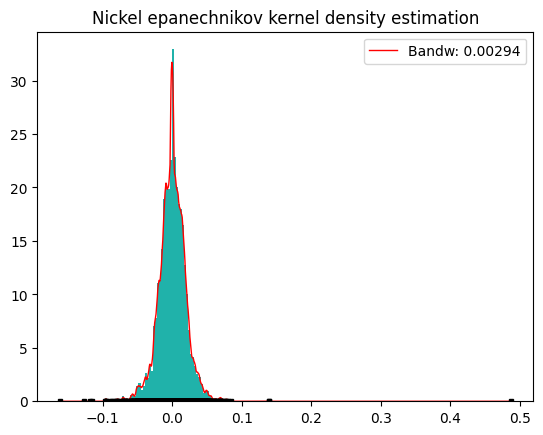

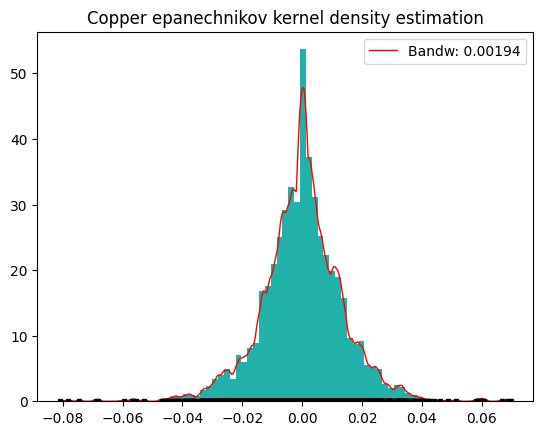

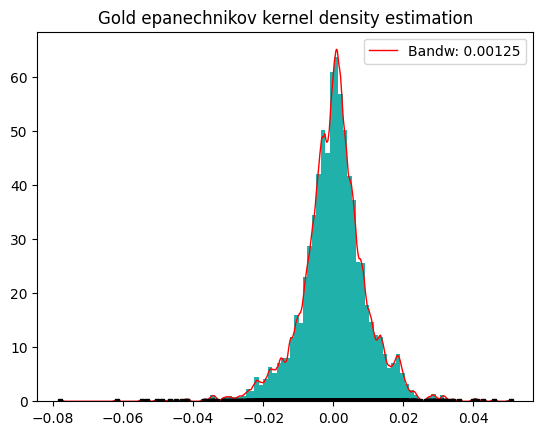

In [4]:
df_kernel = pd.DataFrame()
for asset in SELECTED_ASSETS:
    # KernelDensity requires 2D array, so need to reshape
    dist = X_train[asset].to_numpy().reshape(-1, 1)

    optimized_metrics = {}
    optimized_metrics['silverman'] = bw_silverman(X_train[asset])
    optimized_metrics['scott'] = bw_scott(X_train[asset])

    if KERNEL_BANDWIDTH in ['silverman', 'scott']:
        bandwidth = optimized_metrics[KERNEL_BANDWIDTH]
    else:
        bandwidth = KERNEL_BANDWIDTH

    # x-value range for plotting
    x_range = np.linspace(dist.min(), dist.max(), num=1000)

    # fitting KDE
    kde = KernelDensity(kernel=KERNEL, bandwidth=bandwidth).fit(dist)
    # compute the log-likelihood of each sample
    log_density = kde.score_samples(x_range.reshape(-1,1))
    # df_bandwidth[bandwidth] = log_density

    plt.title(f'{asset} {KERNEL} kernel density estimation')
    plt.hist(X_train[asset], density=True, color='lightseagreen', bins='auto')
    plt.plot(x_range, np.exp(log_density), color='red', linewidth=1, label=f'Bandw: {round(bandwidth,5)}')
    plt.plot(dist, np.zeros_like(dist) , 's', markersize=3, color='black')
    plt.legend()
    plt.show()

    df_kernel[asset] = log_density

# 3. Copula

In [5]:
copula_dict = {
    'gaussian': GaussianCopula(dim=len(SELECTED_ASSETS)),
    'student': StudentCopula(dim=len(SELECTED_ASSETS)),
    'frank': FrankCopula(dim=len(SELECTED_ASSETS)),
    'clayton': ClaytonCopula(dim=len(SELECTED_ASSETS)),
    'gumbel': GumbelCopula(dim=len(SELECTED_ASSETS))
}

copula = copula_dict[COPULA]
copula.fit(df_kernel, to_pobs=True)
print(copula.summary())

copula_simulation = copula.random(n=N_COPULA_SIMULATIONS, seed=RANDOM_SEED)

f:\Apps\anaconda3\envs\semiparametric\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


            Nickel       Copper         Gold
count  1000.000000  1000.000000  1000.000000
mean      0.500000     0.500000     0.500000
std       0.240804     0.288433     0.287443
min       0.336164     0.044456     0.098402
25%       0.336164     0.250500     0.250500
50%       0.336164     0.500000     0.500000
75%       0.749500     0.749500     0.749500
max       0.999001     0.999001     0.999001
Student Copula Summary
Student Copula with 3 dimensions


Parameters
--------------------------------------------------------------------------------
 Degree of Freedom  : 907.4062678084796

 Correlation Matrix 
 1.000000 -0.334944 -0.484313
-0.334944  1.000000  0.799818
-0.484313  0.799818  1.000000



# 4. Portfolio simulations and weight calculation

Expected annual return: 49.9%
Annual volatility: 14.6%
Sharpe Ratio: 3.28


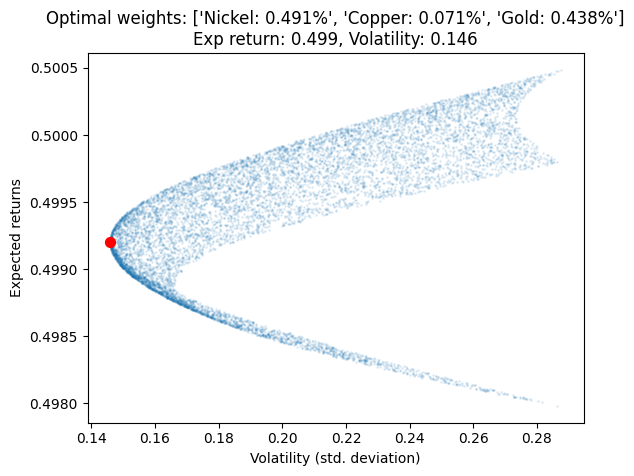

In [6]:
np.random.seed(RANDOM_SEED)

returns = copula_simulation.mean()
dependency_matrix = pd.DataFrame(copula.sigma)
dependency_matrix.columns, dependency_matrix.index = SELECTED_ASSETS, SELECTED_ASSETS
cov_matrix = risk_models.corr_to_cov(dependency_matrix, stdevs=copula_simulation.std())

simulated_df = pd.DataFrame()
for i in range(0, WEIGHT_SIMULATIONS):
    weight_sim = np.random.dirichlet(np.ones(len(SELECTED_ASSETS)), size=1)[0]

    portfolio_return = (weight_sim*np.array(returns)).sum()
    portfolio_volatility = np.sqrt(np.dot(weight_sim.T, np.dot(cov_matrix, weight_sim)))

    row = pd.DataFrame({
        'weights': [weight_sim],
        'exp_return': [portfolio_return],
        'volatility': [portfolio_volatility]
    })
    simulated_df = pd.concat([simulated_df, row], ignore_index=True)

# Portfolio optimization
ef = EfficientFrontier(returns, cov_matrix)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
opt_weights = np.array([weight for weight in cleaned_weights.values()])
opt_return = ef.portfolio_performance()[0]
opt_volatility = ef.portfolio_performance()[1]
ef.portfolio_performance(verbose=True)

printable_weights = [f"{item}: {round(value,3)}%" for (item, value) in cleaned_weights.items()]
plt.scatter(x=simulated_df['volatility'], y=simulated_df['exp_return'], alpha=0.1, s=1)
plt.scatter(x=opt_volatility, y=opt_return, s=50, color='red')
plt.xlabel('Volatility (std. deviation)')
plt.ylabel('Expected returns')
plt.title(f'Optimal weights: {printable_weights}\n'
          f'Exp return: {round(opt_return,3)}, Volatility: {round(opt_volatility,3)}')
plt.show()

# 5. Portfolio testing

In [7]:
testing_portfolio = X_test[SELECTED_ASSETS]
testing_portfolio_return = (opt_weights*np.array(testing_portfolio)).sum()
testing_portfolio_volatility = np.sqrt(np.dot(opt_weights.T, np.dot(testing_portfolio.cov(), opt_weights)))

benchmark = X_test[SELECTED_BENCHMARK]
benchmark_return = benchmark.mean()
benchmark_volatility = benchmark.std()

print(f'Assets in portfolio and calculated weights: {printable_weights}')
print(f'Test period start: {X_TEST_START}. Test period end: {X_TEST_END}')
print(f'Selected portfolio expected return: {round(testing_portfolio_return,3)}, '
      f'volatility: {round(testing_portfolio_volatility,3)}')
print(f'Benchmark ({SELECTED_BENCHMARK}) expected return: {round(benchmark_return,3)}, '
      f'volatility: {round(benchmark_volatility,3)}')

Assets in portfolio and calculated weights: ['Nickel: 0.491%', 'Copper: 0.071%', 'Gold: 0.438%']
Test period start: 2023-01-02. Test period end: 2023-02-28
Selected portfolio expected return: -0.09, volatility: 0.017
Benchmark (SPGSCI) expected return: -0.001, volatility: 0.013
